# Team EDA Baseline (Full Data + R2 Download)

This notebook is the teammate-ready baseline for EDA on the full V1 merged dataset (no additional cleaning/feature engineering in this notebook).

Scope:
- Validate `scripts/r2.env` configuration
- Optionally run `scripts/download_from_r2.sh` to fetch `datasets/<DATASET_VERSION>/`
- Load full parquet partitions as a DuckDB view (`spotify_full`). Pandas is not possible because Dataset is too big for a full EDA.
- Run starter SQL EDA queries (shape, null rates, top regions/charts, yearly streams, audio feature summary)

## 1) Load Project Dependencies and Paths

In [181]:
from pathlib import Path
import os
import re
import json
import subprocess
from typing import Dict, List, Tuple
from sklearn.compose import ColumnTransformer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score

NOTEBOOK_DIR = Path.cwd()
if NOTEBOOK_DIR.name != "Project_Information":
    for candidate in [Path.cwd(), *Path.cwd().parents]:
        if (candidate / "scripts").exists() and (candidate / "datasets").exists():
            NOTEBOOK_DIR = candidate / "Project_Information" if (candidate / "Project_Information").exists() else candidate
            break

REPO_ROOT = NOTEBOOK_DIR.parent if NOTEBOOK_DIR.name == "Project_Information" else NOTEBOOK_DIR
SCRIPTS_DIR = REPO_ROOT / "scripts"
DEFAULT_DATASET_VERSION = "v1"
DEFAULT_DOWNLOAD_ROOT = REPO_ROOT / "datasets" / DEFAULT_DATASET_VERSION
R2_ENV_PATH = SCRIPTS_DIR / "r2.env"
R2_ENV_EXAMPLE_PATH = SCRIPTS_DIR / "r2.env.example"
OUTPUT_DIR = NOTEBOOK_DIR / "outputs" / "team_eda_baseline"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"Repo root: {REPO_ROOT}")
print(f"Scripts dir: {SCRIPTS_DIR}")
print(f"Default download root: {DEFAULT_DOWNLOAD_ROOT}")
print(f"R2 env file: {R2_ENV_PATH}")
print(f"Output dir: {OUTPUT_DIR}")

Repo root: /Users/juliuscaspar/Downloads/CV/Universitys/NOVA MASTERS/Machine Learning/group/ML_Group_AB
Scripts dir: /Users/juliuscaspar/Downloads/CV/Universitys/NOVA MASTERS/Machine Learning/group/ML_Group_AB/scripts
Default download root: /Users/juliuscaspar/Downloads/CV/Universitys/NOVA MASTERS/Machine Learning/group/ML_Group_AB/datasets/v1
R2 env file: /Users/juliuscaspar/Downloads/CV/Universitys/NOVA MASTERS/Machine Learning/group/ML_Group_AB/scripts/r2.env
Output dir: /Users/juliuscaspar/Downloads/CV/Universitys/NOVA MASTERS/Machine Learning/group/ML_Group_AB/Project_Information/outputs/team_eda_baseline


## 2) Parse and Validate `scripts/r2.env` Configuration

In [182]:
REQUIRED_R2_KEYS = [
    "R2_ENDPOINT",
    "R2_BUCKET",
    "AWS_ACCESS_KEY_ID",
    "AWS_SECRET_ACCESS_KEY",
    "DATASET_VERSION",
]


def _strip_balanced_quotes(value: str) -> str:
    if len(value) >= 2 and ((value[0] == '"' and value[-1] == '"') or (value[0] == "'" and value[-1] == "'")):
        return value[1:-1]
    return value


def parse_env_file(env_path: Path) -> Tuple[Dict[str, str], List[str]]:
    parsed: Dict[str, str] = {}
    errors: List[str] = []

    if not env_path.exists():
        errors.append(f"Missing env file: {env_path}")
        return parsed, errors

    for line_no, raw_line in enumerate(env_path.read_text(encoding="utf-8").splitlines(), start=1):
        line = raw_line.strip()
        if not line or line.startswith("#"):
            continue
        if "=" not in line:
            errors.append(f"Line {line_no}: missing '=' separator")
            continue

        key, value = line.split("=", 1)
        key = key.strip()
        value = value.strip()

        if not re.fullmatch(r"[A-Za-z_][A-Za-z0-9_]*", key):
            errors.append(f"Line {line_no}: invalid key '{key}'")
            continue

        dbl_quote_count = value.count('"')
        sgl_quote_count = value.count("'")
        if dbl_quote_count % 2 != 0 or sgl_quote_count % 2 != 0:
            errors.append(
                f"Line {line_no}: malformed quotes for key '{key}' -> {value!r}"
            )
            continue

        normalized = _strip_balanced_quotes(value).strip()

        if normalized.endswith('"') or normalized.endswith("'"):
            errors.append(
                f"Line {line_no}: value for '{key}' appears to have a trailing quote -> {value!r}"
            )

        parsed[key] = normalized

    missing = [k for k in REQUIRED_R2_KEYS if not parsed.get(k)]
    if missing:
        errors.append(f"Missing required keys: {missing}")

    return parsed, errors


r2_config, r2_config_errors = parse_env_file(R2_ENV_PATH)

if r2_config_errors:
    print("❌ r2.env validation failed:")
    for err in r2_config_errors:
        print(f"  - {err}")
    if R2_ENV_EXAMPLE_PATH.exists():
        print(f"\nTemplate available at: {R2_ENV_EXAMPLE_PATH}")
else:
    print("✅ r2.env validation passed")
    display(pd.DataFrame([r2_config]).T.rename(columns={0: "value"}))

✅ r2.env validation passed


,value
R2_ENDPOINT,https://a96b93c5d97cddb48fc674255fb687c7.r2.cl...
R2_BUCKET,ml-group-ab-datasets
AWS_ACCESS_KEY_ID,b4f318900453ff77a06d530e454aa330
AWS_SECRET_ACCESS_KEY,e196e275699090f32d71db4854983855b8b3fc05905a80...
DATASET_VERSION,v1


## 3) Implement Safe Environment Variable Export for Shell Commands

In [183]:
def build_sanitized_env(base_env: Dict[str, str], overrides: Dict[str, str] | None = None) -> Dict[str, str]:
    if r2_config_errors:
        raise ValueError("Cannot build environment: r2.env is invalid.")

    env = dict(os.environ)
    for key in REQUIRED_R2_KEYS:
        env[key] = str(base_env[key]).strip()

    if overrides:
        for k, v in overrides.items():
            if v is not None:
                env[k] = str(v)

    return env


def run_bash_script(script_path: Path, env: Dict[str, str], cwd: Path, timeout: int = 3600) -> subprocess.CompletedProcess:
    if not script_path.exists():
        raise FileNotFoundError(f"Missing script: {script_path}")

    cmd = ["bash", str(script_path)]
    result = subprocess.run(
        cmd,
        cwd=str(cwd),
        env=env,
        capture_output=True,
        text=True,
        timeout=timeout,
    )

    print("--- stdout ---")
    print(result.stdout[-4000:] if result.stdout else "<empty>")
    print("--- stderr ---")
    print(result.stderr[-4000:] if result.stderr else "<empty>")
    print(f"Exit code: {result.returncode}")

    if result.returncode != 0:
        raise RuntimeError(
            "Download script failed. Check stdout/stderr above. "
            "For permission-related preflight errors, try SKIP_R2_PREFLIGHT=1."
        )

    return result

print("✅ Shell helper ready")

✅ Shell helper ready


## 4) Run Dataset Download Script

This cell is safe by default (`RUN_DOWNLOAD = False`). Set it to `True` when ready.

In [184]:
DOWNLOAD_SCRIPT = SCRIPTS_DIR / "download_from_r2.sh"
DATASET_VERSION = r2_config.get("DATASET_VERSION", DEFAULT_DATASET_VERSION) if not r2_config_errors else DEFAULT_DATASET_VERSION
DOWNLOAD_ROOT = REPO_ROOT / "datasets" / DATASET_VERSION

RUN_DOWNLOAD = False  # modify to False to skip actual download

print(f"Default DATASET_VERSION: {DATASET_VERSION}")
print(f"Default DOWNLOAD_ROOT: {DOWNLOAD_ROOT}")

if RUN_DOWNLOAD:
    env_default = build_sanitized_env(
        r2_config,
        overrides={
            "DATASET_VERSION": DATASET_VERSION,
            "DOWNLOAD_ROOT": str(DOWNLOAD_ROOT),
        },
    )
    run_bash_script(DOWNLOAD_SCRIPT, env=env_default, cwd=REPO_ROOT)
else:
    print("Skipped default run. Set RUN_DOWNLOAD=True to execute.")

Default DATASET_VERSION: v1
Default DOWNLOAD_ROOT: /Users/juliuscaspar/Downloads/CV/Universitys/NOVA MASTERS/Machine Learning/group/ML_Group_AB/datasets/v1
Skipped default run. Set RUN_DOWNLOAD=True to execute.


## 5) Load Parquet as DuckDB View (No Full In-Memory DataFrame)

In [185]:
if "DOWNLOAD_ROOT" not in globals():
    fallback_version = (
        r2_config.get("DATASET_VERSION", DEFAULT_DATASET_VERSION)
        if "r2_config" in globals() and "DEFAULT_DATASET_VERSION" in globals()
        else "v1"
    )
    DOWNLOAD_ROOT = REPO_ROOT / "datasets" / fallback_version

active_download_root = DOWNLOAD_ROOT
full_root = active_download_root / "full"
if not full_root.exists():
    raise FileNotFoundError(f"Full dataset folder not found: {full_root}")

parquet_files = sorted(full_root.rglob("*.parquet"))
if not parquet_files:
    raise FileNotFoundError(f"No parquet files found under: {full_root}")

print(f"Active download root: {active_download_root}")
print(f"Total parquet files in full dataset: {len(parquet_files)}")

try:
    import duckdb
except ImportError as exc:
    raise ImportError(
        "duckdb is required for SQL-based EDA. Install it with: pip install duckdb"
    ) from exc

con = duckdb.connect(database=":memory:")
parquet_glob = (full_root / "year=*" / "*.parquet").as_posix()

con.execute(
    f"""
    CREATE OR REPLACE VIEW spotify_full AS
    SELECT *
    FROM read_parquet('{parquet_glob}', hive_partitioning = true);
    """
)

shape_df = con.execute("SELECT COUNT(*) AS row_count, COUNT(*) FILTER (WHERE true) AS sanity FROM spotify_full").df()
schema_df = con.execute("DESCRIBE spotify_full").df()

display(shape_df)
display(schema_df)

print("DuckDB view `spotify_full` is ready. Use SQL queries in the next cell for EDA.")

Active download root: /Users/juliuscaspar/Downloads/CV/Universitys/NOVA MASTERS/Machine Learning/group/ML_Group_AB/datasets/v1
Total parquet files in full dataset: 24


,row_count,sanity
0,26174269,26174269


,column_name,column_type,null,key,default,extra
0,title,VARCHAR,YES,None,None,None
1,rank,VARCHAR,YES,None,None,None
2,date,VARCHAR,YES,None,None,None
3,artist,VARCHAR,YES,None,None,None
4,url,VARCHAR,YES,None,None,None
5,region,VARCHAR,YES,None,None,None
6,chart,VARCHAR,YES,None,None,None
7,trend,VARCHAR,YES,None,None,None
8,streams,VARCHAR,YES,None,None,None
9,track_id,VARCHAR,YES,None,None,None


DuckDB view `spotify_full` is ready. Use SQL queries in the next cell for EDA.


## 6) DuckDB SQL Starter Queries for EDA

These queries are a baseline so teammates can continue EDA with SQL directly on parquet files.

In [186]:
def run_sql(title: str, query: str):
    print(f"\n=== {title} ===")
    display(con.execute(query).df())

run_sql(
    "Rows per year",
    """
    SELECT year, COUNT(*) AS row_count
    FROM spotify_full
    GROUP BY year
    ORDER BY year;
    """,
)

run_sql(
    "Null rates for key EDA columns",
    """
    SELECT
      AVG(CASE WHEN streams IS NULL THEN 1.0 ELSE 0.0 END) AS streams_null_rate,
      AVG(CASE WHEN rank IS NULL THEN 1.0 ELSE 0.0 END) AS rank_null_rate,
      AVG(CASE WHEN region IS NULL THEN 1.0 ELSE 0.0 END) AS region_null_rate,
      AVG(CASE WHEN chart IS NULL THEN 1.0 ELSE 0.0 END) AS chart_null_rate
    FROM spotify_full;
    """,
)

run_sql(
    "Top regions",
    """
    SELECT region, COUNT(*) AS cnt
    FROM spotify_full
    GROUP BY region
    ORDER BY cnt DESC
    LIMIT 15;
    """,
)

run_sql(
    "Top chart types",
    """
    SELECT chart, COUNT(*) AS cnt
    FROM spotify_full
    GROUP BY chart
    ORDER BY cnt DESC
    LIMIT 15;
    """,
)

run_sql(
    "Yearly streams summary",
    """
    SELECT
      year,
      COUNT(*) AS n_rows,
      AVG(TRY_CAST(streams AS DOUBLE)) AS streams_mean,
      MEDIAN(TRY_CAST(streams AS DOUBLE)) AS streams_median,
      SUM(TRY_CAST(streams AS DOUBLE)) AS streams_sum
    FROM spotify_full
    GROUP BY year
    ORDER BY year;
    """,
)

run_sql(
    "Audio feature summary",
    """
    SELECT
      AVG(TRY_CAST(af_danceability AS DOUBLE)) AS danceability_mean,
      AVG(TRY_CAST(af_energy AS DOUBLE)) AS energy_mean,
      AVG(TRY_CAST(af_valence AS DOUBLE)) AS valence_mean,
      AVG(TRY_CAST(af_tempo AS DOUBLE)) AS tempo_mean
    FROM spotify_full;
    """,
)

print("DuckDB starter EDA queries completed. Teammates can now add custom SQL blocks.")


=== Rows per year ===


,year,row_count
0,2017,4401837
1,2018,4863055
2,2019,5412686
3,2020,5793155
4,2021,5703536



=== Null rates for key EDA columns ===


,streams_null_rate,rank_null_rate,region_null_rate,chart_null_rate
0,0.22359,0.0,0.0,0.0



=== Top regions ===


,region,cnt
0,Argentina,455311
1,United States,455085
2,Austria,454596
3,Brazil,454441
4,Australia,453117
5,Canada,452296
6,Global,451804
7,United Kingdom,450732
8,Switzerland,449658
9,Malaysia,449354



=== Top chart types ===


,chart,cnt
0,top200,20321961
1,viral50,5852308



=== Yearly streams summary ===


,year,n_rows,streams_mean,streams_median,streams_sum
0,2017,4401837,51514.662948,9003.0,1.744577e+11
1,2018,4863055,54883.827774,9271.0,2.052286e+11
2,2019,5412686,55452.147561,9631.0,2.334656e+11
3,2020,5793155,55681.434756,9951.0,2.533957e+11
4,2021,5703536,57827.963363,9750.0,2.564694e+11



=== Audio feature summary ===


,danceability_mean,energy_mean,valence_mean,tempo_mean
0,0.685822,0.643769,0.523052,121.163427


DuckDB starter EDA queries completed. Teammates can now add custom SQL blocks.


## 7) EDA



In [187]:
con.execute("SELECT * FROM spotify_full LIMIT 10").df()


,title,rank,date,artist,url,region,chart,trend,streams,track_id,...,country_major_religions,country_govt_type,country_driving_side,cultural_distance_mean,cultural_distance_median,cultural_distance_min,cultural_distance_max,cultural_distance_count,cultural_top5_targets,index
0,Chantaje (feat. Maluma),1,2017-01-01,Shakira,https://open.spotify.com/track/6mICuAdrwEjh6Y6...,Argentina,top200,SAME_POSITION,253019.0,6mICuAdrwEjh6Y6lroV2Kg,...,Christianity,Republic,right,1.279542,1.1075,0.154,4.031,118,Malta|Greece|Italy|Luxembourg|Czech republic,3.0
1,Vente Pa' Ca (feat. Maluma),2,2017-01-01,Ricky Martin,https://open.spotify.com/track/7DM4BPaS7uofFul...,Argentina,top200,MOVE_UP,223988.0,7DM4BPaS7uofFul3ywMe46,...,Christianity,Republic,right,1.279542,1.1075,0.154,4.031,118,Malta|Greece|Italy|Luxembourg|Czech republic,3.0
2,Reggaetón Lento (Bailemos),3,2017-01-01,CNCO,https://open.spotify.com/track/3AEZUABDXNtecAO...,Argentina,top200,MOVE_DOWN,210943.0,3AEZUABDXNtecAOSC1qTfo,...,Christianity,Republic,right,1.279542,1.1075,0.154,4.031,118,Malta|Greece|Italy|Luxembourg|Czech republic,3.0
3,Safari,4,2017-01-01,"J Balvin, Pharrell Williams, BIA, Sky",https://open.spotify.com/track/6rQSrBHf7HlZjtc...,Argentina,top200,SAME_POSITION,173865.0,6rQSrBHf7HlZjtcMZ4S4bO,...,Christianity,Republic,right,1.279542,1.1075,0.154,4.031,118,Malta|Greece|Italy|Luxembourg|Czech republic,3.0
4,Shaky Shaky,5,2017-01-01,Daddy Yankee,https://open.spotify.com/track/58IL315gMSTD37D...,Argentina,top200,MOVE_UP,153956.0,58IL315gMSTD37DOZPJ2hf,...,Christianity,Republic,right,1.279542,1.1075,0.154,4.031,118,Malta|Greece|Italy|Luxembourg|Czech republic,3.0
5,Traicionera,6,2017-01-01,Sebastian Yatra,https://open.spotify.com/track/5J1c3M4EldCfNxX...,Argentina,top200,MOVE_DOWN,151140.0,5J1c3M4EldCfNxXwrwt8mT,...,Christianity,Republic,right,1.279542,1.1075,0.154,4.031,118,Malta|Greece|Italy|Luxembourg|Czech republic,3.0
6,Cuando Se Pone a Bailar,7,2017-01-01,Rombai,https://open.spotify.com/track/1MpKZi1zTXpERKw...,Argentina,top200,MOVE_DOWN,148369.0,1MpKZi1zTXpERKwxmOu1PH,...,Christianity,Republic,right,1.279542,1.1075,0.154,4.031,118,Malta|Greece|Italy|Luxembourg|Czech republic,3.0
7,Otra vez (feat. J Balvin),8,2017-01-01,Zion & Lennox,https://open.spotify.com/track/3QwBODjSEzelZyV...,Argentina,top200,MOVE_DOWN,143004.0,3QwBODjSEzelZyVjxPOHdq,...,Christianity,Republic,right,1.279542,1.1075,0.154,4.031,118,Malta|Greece|Italy|Luxembourg|Czech republic,3.0
8,La Bicicleta,9,2017-01-01,"Carlos Vives, Shakira",https://open.spotify.com/track/0sXvAOmXgjR2QUq...,Argentina,top200,MOVE_UP,126389.0,0sXvAOmXgjR2QUqLK1MltU,...,Christianity,Republic,right,1.279542,1.1075,0.154,4.031,118,Malta|Greece|Italy|Luxembourg|Czech republic,3.0
9,Dile Que Tu Me Quieres,10,2017-01-01,Ozuna,https://open.spotify.com/track/20ZAJdsKB5IGbGj...,Argentina,top200,MOVE_DOWN,112012.0,20ZAJdsKB5IGbGj4ilRt2o,...,Christianity,Republic,right,1.279542,1.1075,0.154,4.031,118,Malta|Greece|Italy|Luxembourg|Czech republic,3.0


In [188]:
# --- Quick sanity checks (DuckDB-based, no full in-memory load) ---


assert "con" in globals(), "DuckDB connection `con` not found. Run sections 4–6 first."
TABLE = "spotify_full"

# Shape (rows, columns)
row_count = con.execute(f"SELECT COUNT(*) AS row_count FROM {TABLE}").df().loc[0, "row_count"]
n_cols = con.execute(f"DESCRIBE {TABLE}").df().shape[0]
print(f"Shape: ({row_count:,} rows, {n_cols} columns)")

# Data types (DuckDB schema)
schema_df = con.execute(f"DESCRIBE {TABLE}").df()
display(schema_df)

# Missingness: compute null rates for all columns (top 15 by null rate)
null_rows = []
for col in schema_df["column_name"].tolist():
    # Quote identifiers safely for DuckDB
    col_quoted = f'"{col}"'
    q = f"""SELECT '{col}' AS column_name,
                    AVG(CASE WHEN {col_quoted} IS NULL THEN 1.0 ELSE 0.0 END) AS null_rate
             FROM {TABLE}"""
    null_rows.append(con.execute(q).df())

null_df = pd.concat(null_rows, ignore_index=True).sort_values("null_rate", ascending=False)
print("\nMissingness (top 15 by null rate):")
display(null_df.head(15))

# Summary stats for numeric-like columns (edit this list to match your modeling target/features)
candidate_numeric = ["streams", "rank", "year", "af_danceability", "af_energy", "af_valence", "af_tempo"]
existing = set(schema_df["column_name"].tolist())
numeric_like = [c for c in candidate_numeric if c in existing]
print("\nNumeric-like columns we will summarize:", numeric_like)

summary_blocks = []
for c in numeric_like:
    c_q = f"TRY_CAST({c} AS DOUBLE)"
    q = f"""SELECT
                '{c}' AS column,
                COUNT(*) AS n_total,
                SUM(CASE WHEN {c} IS NULL THEN 1 ELSE 0 END) AS n_null,
                COUNT({c_q}) AS n_numeric,
                MIN({c_q}) AS min,
                AVG({c_q}) AS mean,
                MEDIAN({c_q}) AS median,
                STDDEV_SAMP({c_q}) AS std,
                MAX({c_q}) AS max
              FROM {TABLE}"""
    summary_blocks.append(con.execute(q).df())

if summary_blocks:
    numeric_summary = pd.concat(summary_blocks, ignore_index=True)
    display(numeric_summary)
else:
    print("No numeric-like columns found from the candidate list. Update `candidate_numeric` above.")


Shape: (26,174,269 rows, 46 columns)


,column_name,column_type,null,key,default,extra
0,title,VARCHAR,YES,None,None,None
1,rank,VARCHAR,YES,None,None,None
2,date,VARCHAR,YES,None,None,None
3,artist,VARCHAR,YES,None,None,None
4,url,VARCHAR,YES,None,None,None
5,region,VARCHAR,YES,None,None,None
6,chart,VARCHAR,YES,None,None,None
7,trend,VARCHAR,YES,None,None,None
8,streams,VARCHAR,YES,None,None,None
9,track_id,VARCHAR,YES,None,None,None



Missingness (top 15 by null rate):


,column_name,null_rate
8,streams,0.223590
45,index,0.193528
44,cultural_top5_targets,0.193528
43,cultural_distance_count,0.193528
42,cultural_distance_max,0.193528
41,cultural_distance_min,0.193528
40,cultural_distance_median,0.193528
39,cultural_distance_mean,0.193528
33,country_population,0.034378
38,country_driving_side,0.034378



Numeric-like columns we will summarize: ['streams', 'rank', 'year', 'af_danceability', 'af_energy', 'af_valence', 'af_tempo']


,column,n_total,n_null,n_numeric,min,mean,median,std,max
0,streams,26174269,5852308.0,20321961,1001.0,55261.251042,9565.000,209586.974960,1.974970e+07
1,rank,26174269,0.0,26174269,1.0,80.921906,67.000,59.185820,2.000000e+02
2,year,26174269,0.0,26174269,2017.0,2019.134999,2019.000,1.390404,2.021000e+03
3,af_danceability,26174269,304251.0,25870018,0.0,0.685822,0.704,0.137278,9.880000e-01
4,af_energy,26174269,304251.0,25870018,0.0,0.643769,0.662,0.166601,1.000000e+00
5,af_valence,26174269,304251.0,25870018,0.0,0.523052,0.523,0.222981,9.990000e-01
6,af_tempo,26174269,304251.0,25870018,0.0,121.163427,118.611,29.399339,2.384310e+02


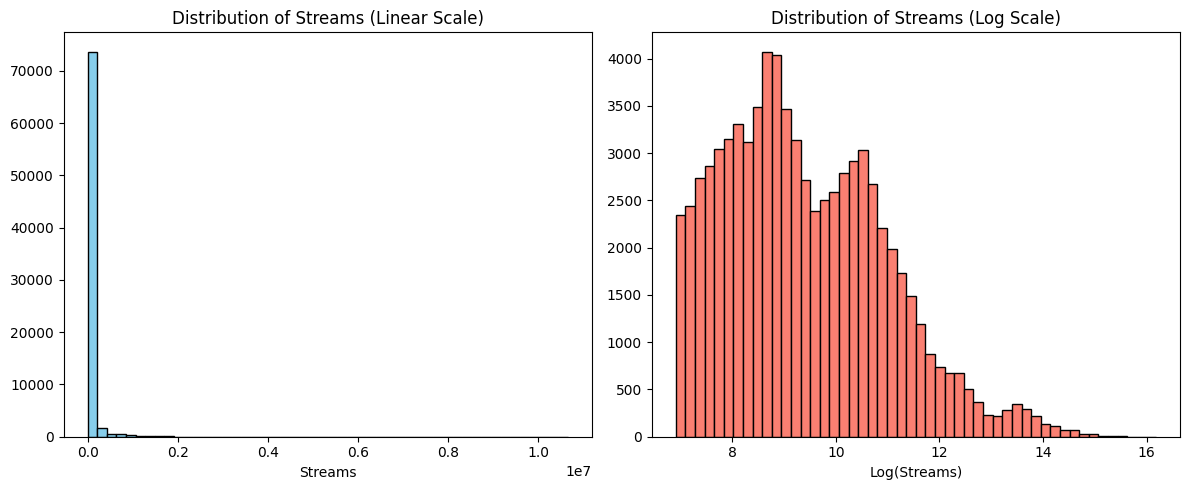

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sample the data for visualization (as the dataset is too big for full pandas plotting)
sample_df = con.execute("SELECT TRY_CAST(streams AS DOUBLE) as streams FROM spotify_full WHERE streams IS NOT NULL USING SAMPLE 100000").df()

plt.figure(figsize=(12, 5))

# Plot 1: Standard Distribution
plt.subplot(1, 2, 1)
plt.hist(sample_df['streams'], bins=50, color='skyblue', edgecolor='black')
plt.title("Distribution of Streams (Linear Scale)")
plt.xlabel("Streams")

# Plot 2: Log Distribution 
plt.subplot(1, 2, 2)
plt.hist(np.log1p(sample_df['streams']), bins=50, color='salmon', edgecolor='black')
plt.title("Distribution of Streams (Log Scale)")
plt.xlabel("Log(Streams)")

plt.tight_layout()
plt.show()

#### Due to Highly Skewed Data we decided to look at the Log Streams

## 8) Audio Feature Distributions

We inspect each numeric audio feature's distribution using a representative **50 000-row random sample**.
By doing so we can examinine feature distributions before building any model.


In [190]:
# Pull a 50 000-row random sample for plotting (avoids loading 26M rows into memory)
SAMPLE_SIZE = 50_000

sample_df = con.execute(f"""
    SELECT
        TRY_CAST(streams AS DOUBLE) AS streams,
        TRY_CAST(af_danceability AS DOUBLE) AS danceability,
        TRY_CAST(af_energy AS DOUBLE) AS energy,
        TRY_CAST(af_valence AS DOUBLE) AS valence,
        TRY_CAST(af_tempo AS DOUBLE) AS tempo,
        TRY_CAST(af_loudness AS DOUBLE) AS loudness,
        TRY_CAST(af_acousticness AS DOUBLE) AS acousticness,
        TRY_CAST(af_speechiness AS DOUBLE) AS speechiness,
        TRY_CAST(af_instrumentalness AS DOUBLE) AS instrumentalness,
        TRY_CAST(af_liveness AS DOUBLE) AS liveness,
        TRY_CAST(rank AS DOUBLE) AS rank,
        TRY_CAST(popularity AS DOUBLE) AS popularity,
        chart,
        explicit,
        country_continent,
        year
    FROM spotify_full
    USING SAMPLE {SAMPLE_SIZE} ROWS
""").df()

# Add log_streams
sample_df["log_streams"] = np.log1p(sample_df["streams"].clip(lower=0))

print(f"Sample shape: {sample_df.shape}")
print("\nSample describe (numeric features):")
display(sample_df.describe())


Sample shape: (50000, 17)

Sample describe (numeric features):


,streams,danceability,energy,valence,tempo,loudness,acousticness,speechiness,instrumentalness,liveness,rank,popularity,year,log_streams
count,3.887700e+04,49407.000000,49407.000000,49407.000000,49407.000000,49407.000000,49407.000000,49407.000000,49407.000000,49407.000000,50000.000000,49407.000000,50000.000000,38877.000000
mean,5.517938e+04,0.685637,0.643687,0.523954,121.157810,-6.235678,0.257478,0.109829,0.012986,0.170471,80.715480,46.790313,2019.135220,9.387882
std,1.989027e+05,0.136545,0.166844,0.223122,29.348429,2.494970,0.247263,0.100271,0.082558,0.130419,59.241907,30.786920,1.393102,1.569027
min,1.001000e+03,0.077000,0.000138,0.032000,35.316000,-34.866000,0.000001,0.022600,0.000000,0.016100,1.000000,0.000000,2017.000000,6.909753
25%,3.431000e+03,0.601000,0.535000,0.349000,97.011000,-7.460000,0.055600,0.042700,0.000000,0.093500,29.000000,9.000000,2018.000000,8.140898
50%,9.340000e+03,0.704000,0.661000,0.524000,118.894000,-5.857000,0.175000,0.067400,0.000000,0.120000,66.000000,57.000000,2019.000000,9.142169
75%,3.534200e+04,0.784000,0.770000,0.699000,140.019500,-4.521000,0.397000,0.136000,0.000028,0.200000,131.000000,73.000000,2020.000000,10.472856
max,7.393443e+06,0.985000,0.999000,0.982000,230.186000,1.509000,0.996000,0.957000,0.968000,0.988000,200.000000,96.000000,2021.000000,15.816104


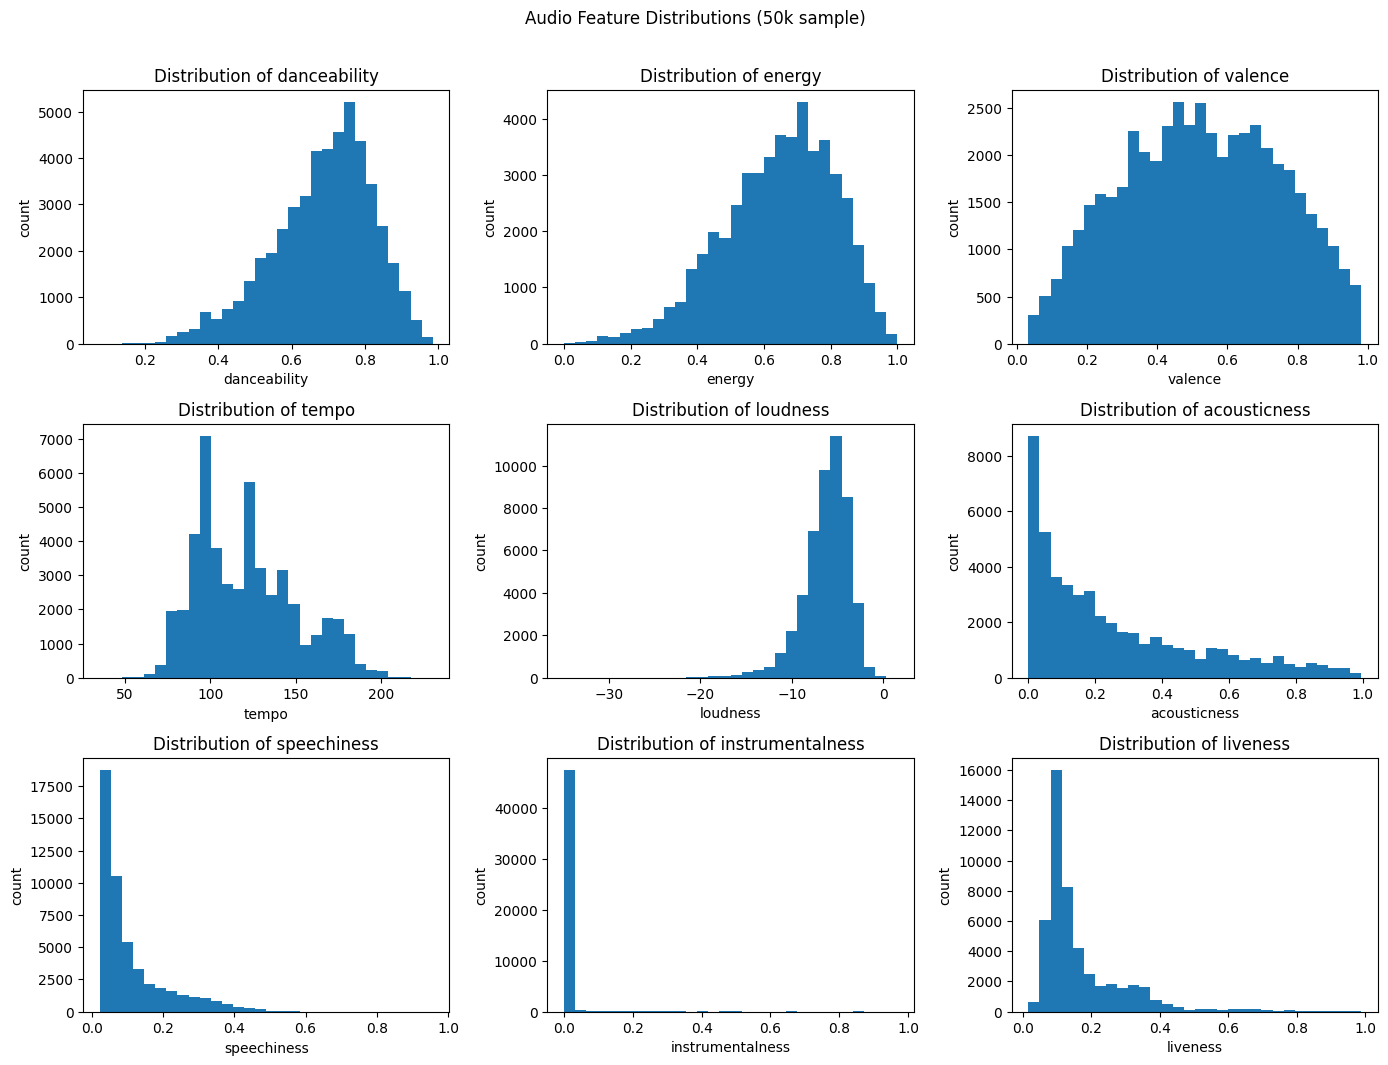

In [ ]:
# Histograms of all numeric audio features 
audio_features = ["danceability", "energy", "valence", "tempo",
                   "loudness", "acousticness", "speechiness",
                   "instrumentalness", "liveness"]

n_cols = 3
n_rows = (len(audio_features) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 3.5))
axes = axes.ravel()

for i, feat in enumerate(audio_features):
    data = sample_df[feat].dropna()
    axes[i].hist(data, bins=30, edgecolor="none")
    axes[i].set_title(f"Distribution of {feat}")
    axes[i].set_xlabel(feat)
    axes[i].set_ylabel("count")

# Hide unused axes
for j in range(len(audio_features), len(axes)):
    axes[j].set_visible(False)

plt.suptitle("Audio Feature Distributions (50k sample)", y=1.01)
plt.tight_layout()
plt.show()


## 9) Streams vs. Numeric Features (Scatter Plots)

we plot `log(streams)` against each audio feature
to visually assess linear relationships before fitting a model.
We use `log(streams)` on the y-axis because the raw target is heavily right-skewed.


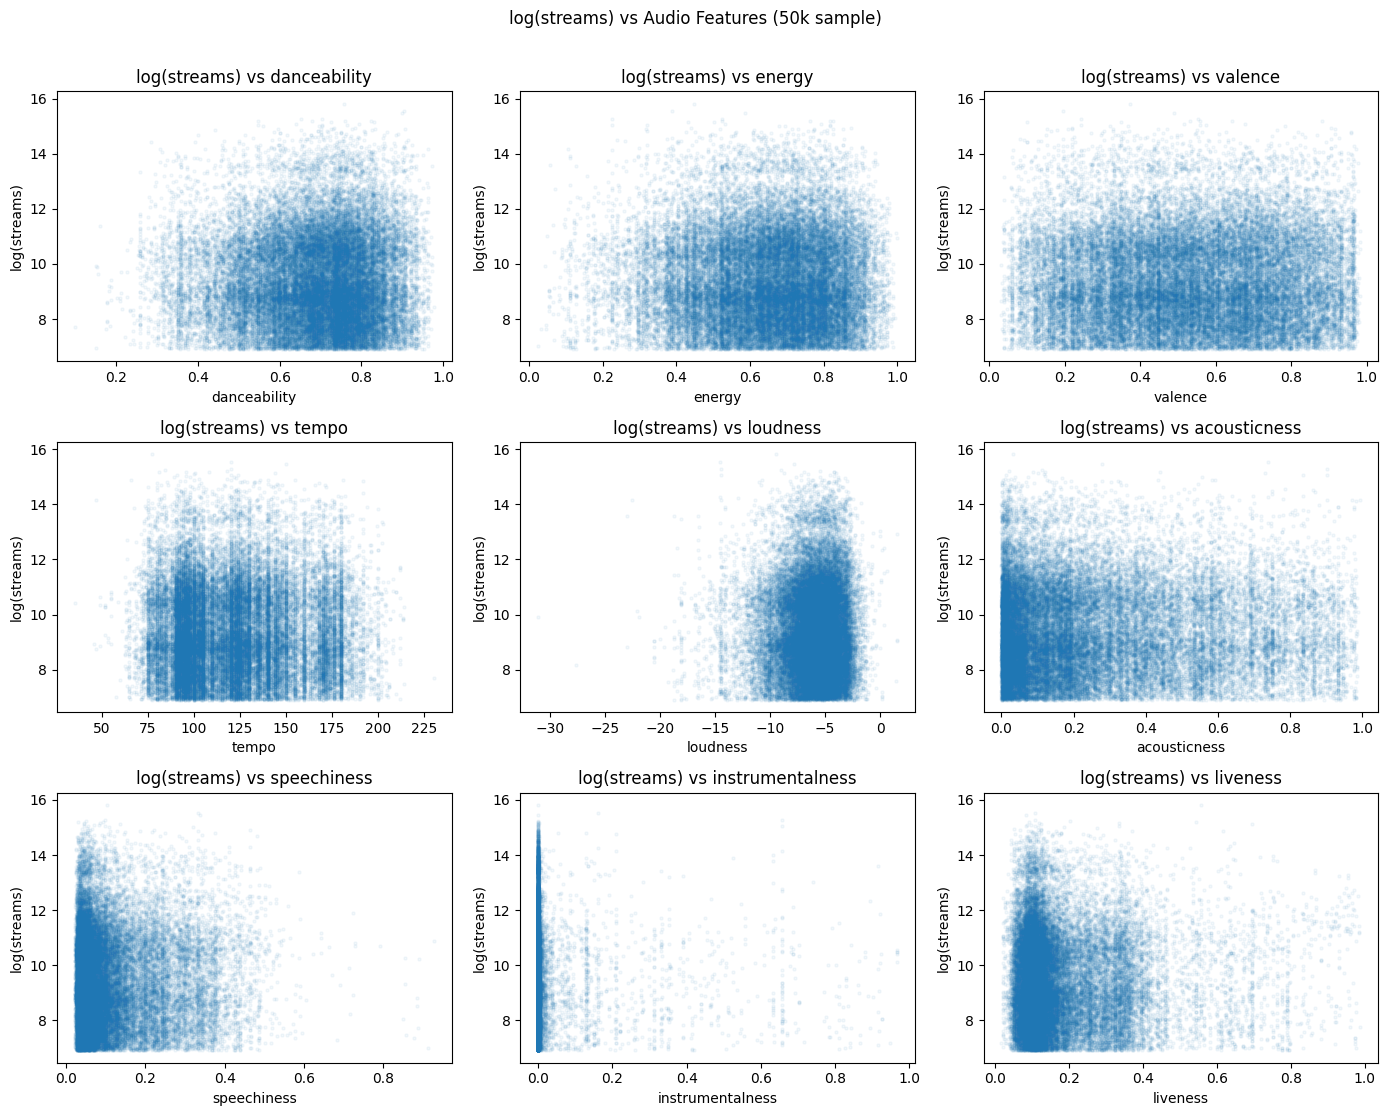

In [192]:
fig, axes = plt.subplots(3, 3, figsize=(14, 11))
axes = axes.ravel()

for i, feat in enumerate(audio_features):
    x = sample_df[feat].dropna()
    y = sample_df.loc[x.index, "log_streams"].dropna()
    common = x.index.intersection(y.index)
    axes[i].scatter(x[common], y[common], alpha=0.05, s=5)
    axes[i].set_title(f"log(streams) vs {feat}")
    axes[i].set_xlabel(feat)
    axes[i].set_ylabel("log(streams)")

plt.suptitle("log(streams) vs Audio Features (50k sample)", y=1.01)
plt.tight_layout()
plt.show()


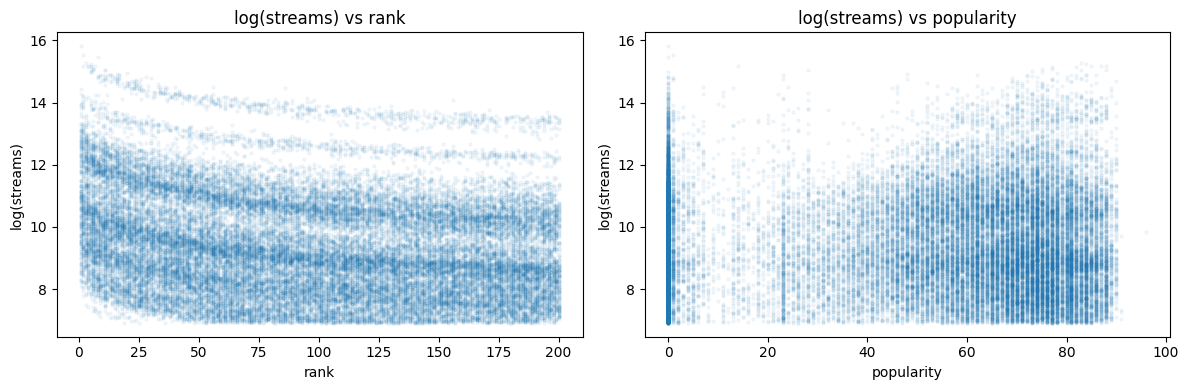

In [193]:
# Also: streams vs rank and popularity
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for ax, feat in zip(axes, ["rank", "popularity"]):
    mask = sample_df[feat].notna() & sample_df["log_streams"].notna()
    ax.scatter(sample_df.loc[mask, feat], sample_df.loc[mask, "log_streams"],
               alpha=0.05, s=5)
    ax.set_title(f"log(streams) vs {feat}")
    ax.set_xlabel(feat)
    ax.set_ylabel("log(streams)")

plt.tight_layout()
plt.show()


## 10) Categorical Effects on Streams (Box Plots)


Here we show `log(streams)` broken down by `chart` type, `explicit` flag, and `country_continent`.


/var/folders/19/93krsqv97cg550yjxmp0k48m0000gn/T/ipykernel_47994/2191605110.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(groups, labels=labels, vert=True)
/var/folders/19/93krsqv97cg550yjxmp0k48m0000gn/T/ipykernel_47994/2191605110.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(groups, labels=labels, vert=True)
/var/folders/19/93krsqv97cg550yjxmp0k48m0000gn/T/ipykernel_47994/2191605110.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(groups, labels=labels, vert=True)


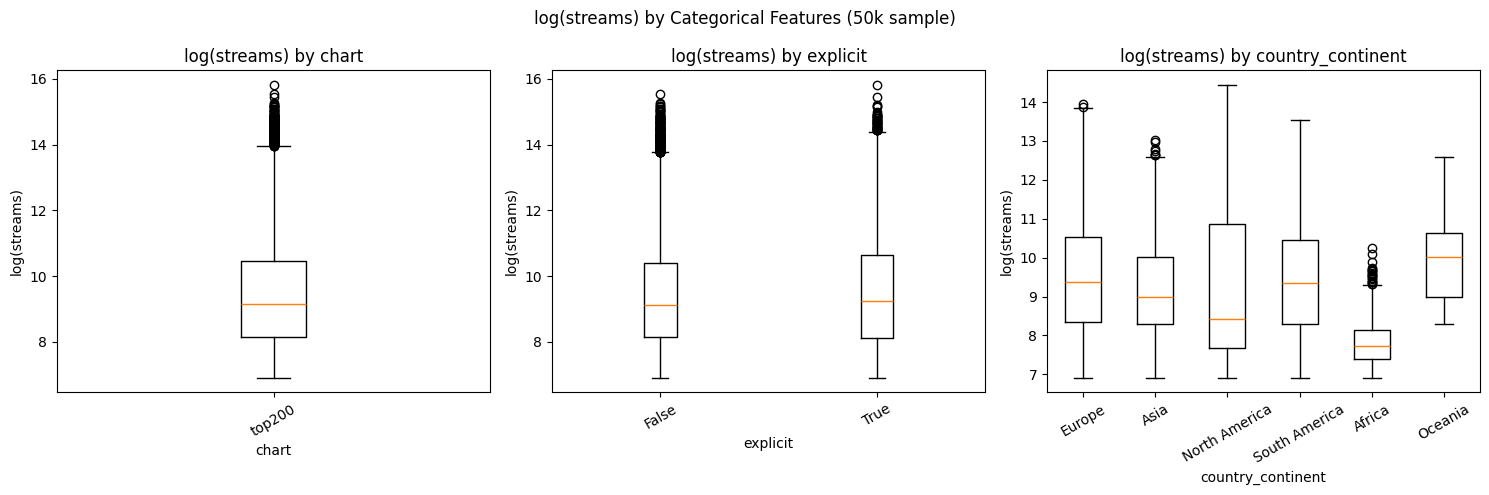

In [194]:
cat_cols = ["chart", "explicit", "country_continent"]

fig, axes = plt.subplots(1, len(cat_cols), figsize=(15, 5))

for ax, col in zip(axes, cat_cols):
    # Group data for boxplot
    groups = [
        sample_df.loc[sample_df[col] == cat, "log_streams"].dropna().values
        for cat in sample_df[col].dropna().unique()
    ]
    labels = list(sample_df[col].dropna().unique())
    # Filter out empty groups
    pairs = [(g, l) for g, l in zip(groups, labels) if len(g) > 0]
    if pairs:
        groups, labels = zip(*pairs)
        ax.boxplot(groups, labels=labels, vert=True)
        ax.set_title(f"log(streams) by {col}")
        ax.set_xlabel(col)
        ax.set_ylabel("log(streams)")
        ax.tick_params(axis="x", rotation=30)

plt.suptitle("log(streams) by Categorical Features (50k sample)")
plt.tight_layout()
plt.show()


/var/folders/19/93krsqv97cg550yjxmp0k48m0000gn/T/ipykernel_47994/2462357888.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(year_groups, labels=year_labels)


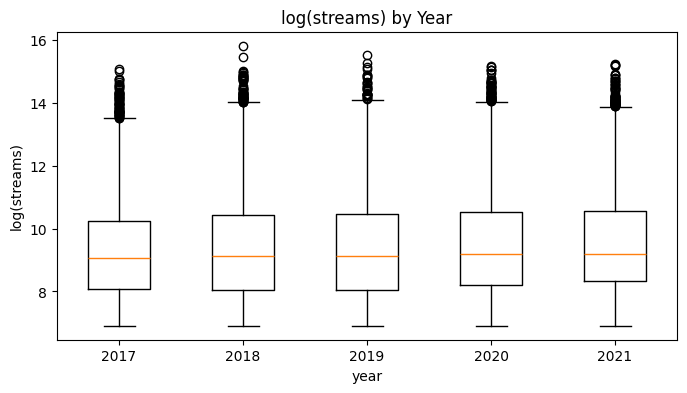

In [195]:
# Year-over-year trend boxplot 
year_groups = [
    sample_df.loc[sample_df["year"] == yr, "log_streams"].dropna().values
    for yr in sorted(sample_df["year"].dropna().unique())
]
year_labels = [str(int(yr)) for yr in sorted(sample_df["year"].dropna().unique())]

plt.figure(figsize=(8, 4))
plt.boxplot(year_groups, labels=year_labels)
plt.title("log(streams) by Year")
plt.xlabel("year")
plt.ylabel("log(streams)")
plt.show()


## 11) Correlation Matrix

Before modelling we inspect pairwise correlations between the numeric features and the target.
High correlations between features signal potential multicollinearity.


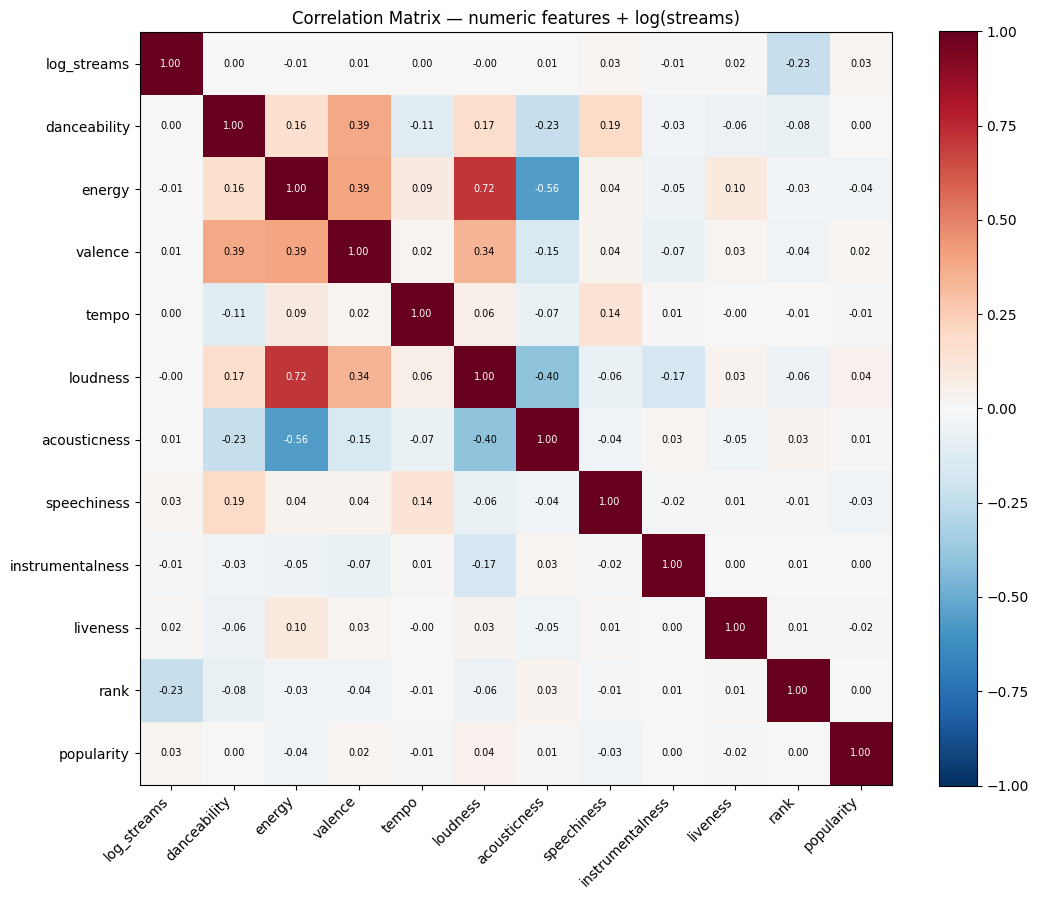


Correlations with log(streams) (sorted):
rank               -0.231829
popularity          0.028272
speechiness         0.027446
liveness            0.015204
instrumentalness   -0.008190
energy             -0.006802
acousticness        0.005327
valence             0.005145
danceability        0.002692
tempo               0.002423
loudness           -0.001133


In [196]:
numeric_cols_for_corr = ["log_streams", "danceability", "energy", "valence",
                          "tempo", "loudness", "acousticness", "speechiness",
                          "instrumentalness", "liveness", "rank", "popularity"]

corr = sample_df[numeric_cols_for_corr].dropna().corr()

fig, ax = plt.subplots(figsize=(11, 9))
im = ax.imshow(corr.values, vmin=-1, vmax=1, cmap="RdBu_r")
plt.colorbar(im, ax=ax)

ax.set_xticks(range(len(corr.columns)))
ax.set_yticks(range(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=45, ha="right")
ax.set_yticklabels(corr.columns)

for i in range(len(corr.columns)):
    for j in range(len(corr.columns)):
        ax.text(j, i, f"{corr.iloc[i, j]:.2f}",
                ha="center", va="center", fontsize=7,
                color="white" if abs(corr.iloc[i, j]) > 0.5 else "black")

ax.set_title("Correlation Matrix — numeric features + log(streams)")
plt.tight_layout()
plt.show()

# Print top correlations with target
print("\nCorrelations with log(streams) (sorted):")
print(corr["log_streams"].drop("log_streams").sort_values(key=abs, ascending=False).to_string())


## 12) Split + Preprocess (without data leakage)
- Identify numeric and categorical features
- Build a `Pipeline` with `StandardScaler` for numeric and `OneHotEncoder` for categorical
- Perform a **75 / 25 train / test split** (`random_state=42`)

Because the full 26M-row dataset cannot fit into pandas memory, we use the **50k random sample**
already pulled in section 8. This gives a realistic and reproducible modelling baseline.

**Why a pipeline?**
- Prevents *data leakage* (scaler / encoder is fit only on train data during `.fit()`)
- Makes cross-validation safe and straightforward


In [197]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# ── Define features and target ──
TARGET = "log_streams"

NUMERIC_FEATURES = [
    "danceability", "energy", "valence", "tempo",
    "loudness", "acousticness", "speechiness",
    "instrumentalness", "liveness", "popularity"
]
CATEGORICAL_FEATURES = ["chart", "explicit", "country_continent"]

# Drop rows where target or any feature is missing
model_df = sample_df[NUMERIC_FEATURES + CATEGORICAL_FEATURES + [TARGET]].dropna()
print(f"Modelling sample after dropping NaNs: {model_df.shape}")

X = model_df[NUMERIC_FEATURES + CATEGORICAL_FEATURES]
y = model_df[TARGET]

# ── Build preprocessing pipeline ──
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), NUMERIC_FEATURES),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), CATEGORICAL_FEATURES),
    ],
    remainder="drop",
)

# ── Train / test split ──
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE
)

print(f"Train size: {X_train.shape}  Test size: {X_test.shape}")


Modelling sample after dropping NaNs: (37480, 14)
Train size: (28110, 13)  Test size: (9370, 13)


## 13) Baseline: Linear Regression

We fit a standard **least-squares linear regression**
and evaluate with:

- **RMSE** (in log-streams units)
- **R²** (fraction of variance explained)

**Checkpoint (think about these before running the next cell):**
- What does RMSE mean here if our target is `log(streams)`?
- What R² would you consider "good" for streaming data?


In [198]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# ── Fit linear regression pipeline ──
lr_pipe = Pipeline([
    ("preprocess", preprocess),
    ("model", LinearRegression()),
])

lr_pipe.fit(X_train, y_train)

# ── Predictions ──
y_train_pred = lr_pipe.predict(X_train)
y_test_pred  = lr_pipe.predict(X_test)

# ── Metrics ──
print("=== Linear Regression — Train ===")
print(f"  RMSE : {rmse(y_train, y_train_pred):.4f}")
print(f"  R²   : {r2_score(y_train, y_train_pred):.4f}")

print("\n=== Linear Regression — Test ===")
print(f"  RMSE : {rmse(y_test, y_test_pred):.4f}")
print(f"  R²   : {r2_score(y_test, y_test_pred):.4f}")

# ── Cross-validation on train set ──
cv_r2 = cross_val_score(lr_pipe, X_train, y_train, cv=5, scoring="r2")
print(f"\n5-fold CV R²: {cv_r2.mean():.4f} ± {cv_r2.std():.4f}")


=== Linear Regression — Train ===
  RMSE : 1.4339
  R²   : 0.0422

=== Linear Regression — Test ===
  RMSE : 1.4336
  R²   : 0.0391

5-fold CV R²: 0.0409 ± 0.0053


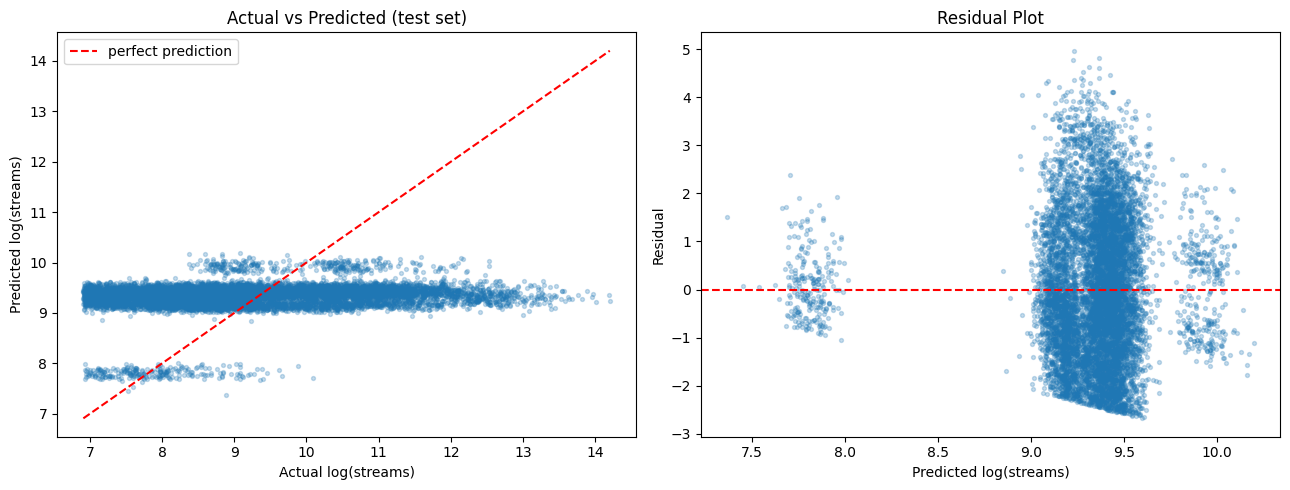

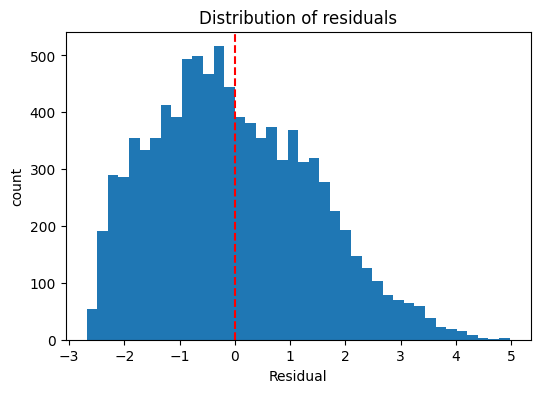

In [ ]:
# ── Actual vs Predicted — diagnostic plot ──
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# Actual vs Predicted
axes[0].scatter(y_test, y_test_pred, alpha=0.25, s=8)
lo = min(y_test.min(), y_test_pred.min())
hi = max(y_test.max(), y_test_pred.max())
axes[0].plot([lo, hi], [lo, hi], "r--", lw=1.5, label="perfect prediction")
axes[0].set_xlabel("Actual log(streams)")
axes[0].set_ylabel("Predicted log(streams)")
axes[0].set_title("Actual vs Predicted (test set)")
axes[0].legend()

# Residuals
residuals = y_test.values - y_test_pred
axes[1].scatter(y_test_pred, residuals, alpha=0.25, s=8)
axes[1].axhline(0, color="red", lw=1.5, linestyle="--")
axes[1].set_xlabel("Predicted log(streams)")
axes[1].set_ylabel("Residual")
axes[1].set_title("Residual Plot")

plt.tight_layout()
plt.show()

# Residual distribution
plt.figure(figsize=(6, 4))
plt.hist(residuals, bins=40, edgecolor="none")
plt.axvline(0, color="red", linestyle="--")
plt.title("Distribution of residuals")
plt.xlabel("Residual")
plt.ylabel("count")
plt.show()




## 14) Coefficient Inspection

statsmodels OLS summary. We extract the linear regression coefficients
to understand which features drive the model.


Top 15 most influential features (by |coefficient|):


,feature,coefficient,abs_coefficient
14,country_continent_Oceania,2.115934,2.115934
15,country_continent_South America,1.676621,1.676621
12,country_continent_Europe,1.622606,1.622606
13,country_continent_North America,1.448388,1.448388
11,country_continent_Asia,1.360134,1.360134
10,explicit_True,0.114547,0.114547
5,acousticness,0.033153,0.033153
0,danceability,-0.028638,0.028638
2,valence,0.025234,0.025234
8,liveness,0.023537,0.023537



Model Intercept: 7.767410100764615


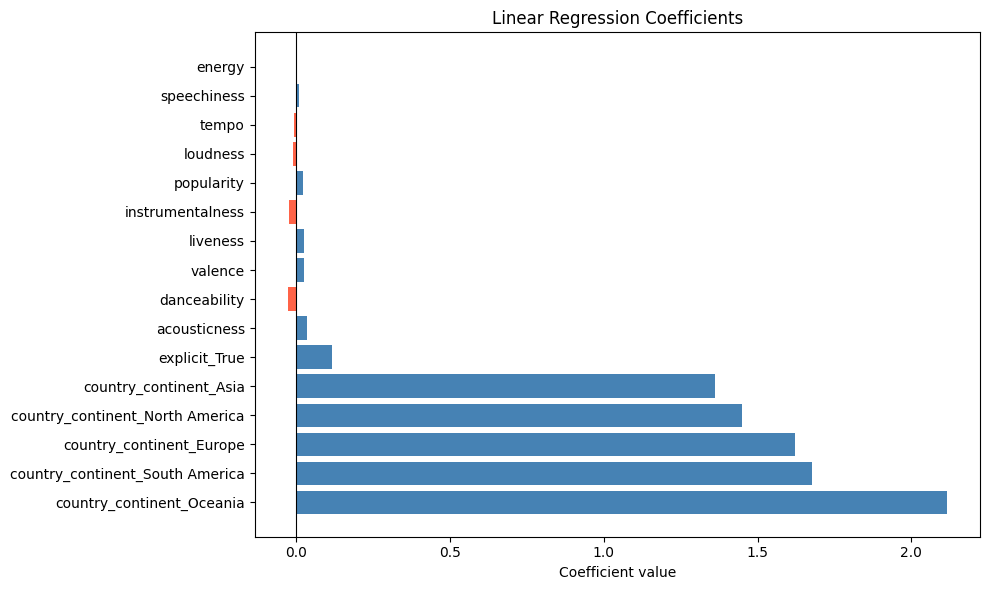

In [200]:
# Extract feature names after preprocessing
ohe_cats = lr_pipe.named_steps["preprocess"].named_transformers_["cat"].get_feature_names_out(CATEGORICAL_FEATURES).tolist()
feature_names = NUMERIC_FEATURES + ohe_cats

# Create DataFrame with normal and absolute coefficients
coef_df = pd.DataFrame({
    "feature": feature_names,
    "coefficient": lr_pipe.named_steps["model"].coef_,
})
# Calculate the absolute value of the coefficients
coef_df["abs_coefficient"] = coef_df["coefficient"].abs()

# Sort by absolute value and display the top 15
coef_df = coef_df.sort_values("abs_coefficient", ascending=False)
print("Top 15 most influential features (by |coefficient|):")
display(coef_df.head(15))

# Extract and print the model intercept
intercept = lr_pipe.named_steps["model"].intercept_
print(f"\nModel Intercept: {intercept}")

# Bar chart of all coefficients
fig, ax = plt.subplots(figsize=(10, 6))
# Ensure chart remains sorted by influence for readability
colors = ["steelblue" if c >= 0 else "tomato" for c in coef_df["coefficient"]]
ax.barh(coef_df["feature"], coef_df["coefficient"], color=colors)
ax.axvline(0, color="black", lw=0.8)
ax.set_title("Linear Regression Coefficients")
ax.set_xlabel("Coefficient value")
plt.tight_layout()
plt.show()

## Interpreting the linear model coefficients (what increases/decreases predictions)

**Rule:**  
- **Positive coefficient (+)** → increases the prediction  
- **Negative coefficient (−)** → decreases the prediction  
- For **dummy variables** (e.g., `country_continent_Europe`), the coefficient is the effect **relative to the omitted reference category** (the continent that has no dummy).

### If the target is `log(streams)` (as in our EDA)
Then coefficients are easiest to read as **multiplicative / % effects**:

- A coefficient **β** corresponds to multiplying streams by **exp(β)**  
- Approx. percent change: **(exp(β) − 1) × 100%**

### Which variables increase predictions?
Largest positive effects (vs. reference continent):
- `country_continent_Oceania` **(+2.059)** → exp(2.059) ≈ **7.84×** (≈ **+684%**)
- `country_continent_South America` **(+1.618)** → ≈ **5.05×** (≈ **+405%**)
- `country_continent_Europe` **(+1.600)** → ≈ **4.95×** (≈ **+395%**)
- `country_continent_North America` **(+1.482)** → ≈ **4.40×** (≈ **+340%**)
- `country_continent_Asia` **(+1.267)** → ≈ **3.55×** (≈ **+255%**)

Other positive effects:
- `explicit_True` **(+0.086)** → exp(0.086) ≈ **1.09×** (≈ **+9%**)
- Small positives: `acousticness`, `liveness`, `valence`, `tempo`, `popularity`, `energy`

### Which variables decrease predictions?
- `danceability` **(−0.027)**
- `instrumentalness` **(−0.021)**
- `loudness` **(−0.020)**

(If the target is log(streams), β = −0.027 means exp(−0.027) ≈ **0.973×** → about **−2.7%** for a +1 unit change in that feature.)

### Are effects large or small?
- **Very large:** the **continent dummies** (coefficients ~1.3–2.1) dominate the model → they change predictions by **multiples**.
- **Medium:** `explicit_True` (~0.086) → around **single-digit %** effect.
- **Small:** most audio features have |β| around **0.02–0.03** (small changes in predicted log(streams)).

 Important: comparing “importance” by |coefficient| only makes sense if features are on **similar scales** (e.g., standardized). If not standardized, coefficient size also reflects the feature’s units (tempo in BPM, popularity 0–100, etc.).

### Are signs intuitive?
- **Instrumentalness negative**: intuitive (instrumentals often stream less in mainstream charts).
- **Popularity positive**: intuitive.
- **Continent effects**: plausible (differences in market size / Spotify usage / chart mechanics), but not causal.
- **Danceability negative / loudness negative**: might be counterintuitive and can depend on **scaling**, omitted variables, or correlations among features (multicollinearity). These signs should be discussed as “associations,” not causal effects.

**Intercept:** 7.83 means the baseline prediction (when all features = 0 and the reference categories apply) is **log(streams)=7.83** (streams ≈ exp(7.83) ≈ 2,517), but this baseline may not be realistic if “0” is outside typical feature values.


## 15) Regularization: Ridge | Lasso | ElasticNet

### Why Regularization?
Real datasets often have:
- Multicollinearity (e.g. energy and loudness are correlated)
- Noise
- Many one-hot-encoded dummy features

**Ridge** adds an L2 penalty to shrink all coefficients; **Lasso** adds an L1 penalty and can zero out irrelevant features.
Both reduce overfitting and improve generalization.**ElasticNet** is a modebel which behaves like Ridge (stable) + Lasso (some selection)
,especially good when predictors are correlated and you want interpretability.

In [201]:
rows = []

ridge_alphas = [0.001, 0.01, 0.1, 1, 10, 100]
lasso_alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
enet_alphas  = [0.001, 0.01, 0.1, 1, 10, 100]
l1_ratios    = [0.2, 0.5, 0.8]

# --- LinearRegression ---
pipe = Pipeline([("preprocess", preprocess), ("model", LinearRegression())])
pipe.fit(X_train, y_train)
rows.append({
    "train_rmse": rmse(y_train, pipe.predict(X_train)),
    "test_rmse":  rmse(y_test,  pipe.predict(X_test)),
    "train_r2":   r2_score(y_train, pipe.predict(X_train)),
    "test_r2":    r2_score(y_test,  pipe.predict(X_test)),
    "model":      "LinearRegression",
    "alpha":      np.nan
})

# --- Ridge ---
for a in ridge_alphas:
    pipe = Pipeline([("preprocess", preprocess), ("model", Ridge(alpha=a))])
    pipe.fit(X_train, y_train)
    rows.append({
        "train_rmse": rmse(y_train, pipe.predict(X_train)),
        "test_rmse":  rmse(y_test,  pipe.predict(X_test)),
        "train_r2":   r2_score(y_train, pipe.predict(X_train)),
        "test_r2":    r2_score(y_test,  pipe.predict(X_test)),
        "model":      "Ridge",
        "alpha":      a
    })

# --- Lasso ---
for a in lasso_alphas:
    pipe = Pipeline([("preprocess", preprocess), ("model", Lasso(alpha=a, max_iter=20000))])
    pipe.fit(X_train, y_train)
    rows.append({
        "train_rmse": rmse(y_train, pipe.predict(X_train)),
        "test_rmse":  rmse(y_test,  pipe.predict(X_test)),
        "train_r2":   r2_score(y_train, pipe.predict(X_train)),
        "test_r2":    r2_score(y_test,  pipe.predict(X_test)),
        "model":      "Lasso",
        "alpha":      a
    })

# --- ElasticNet (encode l1_ratio into model name so column isn't needed) ---
for a in enet_alphas:
    for r in l1_ratios:
        pipe = Pipeline([("preprocess", preprocess),
                         ("model", ElasticNet(alpha=a, l1_ratio=r, max_iter=20000))])
        pipe.fit(X_train, y_train)
        rows.append({
            "train_rmse": rmse(y_train, pipe.predict(X_train)),
            "test_rmse":  rmse(y_test,  pipe.predict(X_test)),
            "train_r2":   r2_score(y_train, pipe.predict(X_train)),
            "test_r2":    r2_score(y_test,  pipe.predict(X_test)),
            "model":      f"ElasticNet(r={r})",
            "alpha":      a
        })

results_df = pd.DataFrame(rows)
results_df[["train_rmse","test_rmse","train_r2","test_r2"]] = results_df[["train_rmse","test_rmse","train_r2","test_r2"]].round(6)
results_df["alpha"] = results_df["alpha"].round(6)

results_df = results_df.sort_values(["test_rmse", "test_r2"], ascending=[True, False]).reset_index(drop=True)
display(results_df)


,train_rmse,test_rmse,train_r2,test_r2,model,alpha
0,1.434040,1.433590,0.042003,0.039134,Ridge,10.0000
1,1.433933,1.433620,0.042146,0.039095,Lasso,0.0001
2,1.433930,1.433629,0.042150,0.039082,Ridge,1.0000
3,1.433929,1.433644,0.042151,0.039062,Ridge,0.1000
4,1.433929,1.433646,0.042151,0.039060,LinearRegression,NaN
5,1.433929,1.433646,0.042151,0.039060,Ridge,0.0010
6,1.433929,1.433646,0.042151,0.039060,Ridge,0.0100
7,1.434308,1.433732,0.041645,0.038945,Lasso,0.0010
8,1.434371,1.433768,0.041561,0.038896,ElasticNet(r=0.8),0.0010
9,1.434465,1.433827,0.041436,0.038817,ElasticNet(r=0.5),0.0010


Best config per model family (by test RMSE):


,model,alpha,test_rmse,test_r2
0,ElasticNet(r=0.2),0.0010,1.433889,0.038734
1,ElasticNet(r=0.5),0.0010,1.433827,0.038817
2,ElasticNet(r=0.8),0.0010,1.433768,0.038896
3,Lasso,0.0001,1.433620,0.039095
4,LinearRegression,NaN,1.433646,0.039060
5,Ridge,10.0000,1.433590,0.039134


ElasticNet(r=0.2)  (alpha=0.001)
  CV RMSE per fold : [1.4243 1.4273 1.4591 1.4344 1.432 ]
  Mean CV RMSE     : 1.4354
  Std  CV RMSE     : 0.0123

ElasticNet(r=0.5)  (alpha=0.001)
  CV RMSE per fold : [1.4243 1.4272 1.459  1.4343 1.4319]
  Mean CV RMSE     : 1.4353
  Std  CV RMSE     : 0.0123

ElasticNet(r=0.8)  (alpha=0.001)
  CV RMSE per fold : [1.4242 1.427  1.4589 1.4343 1.4318]
  Mean CV RMSE     : 1.4352
  Std  CV RMSE     : 0.0123

Lasso  (alpha=0.0001)
  CV RMSE per fold : [1.4239 1.4263 1.4584 1.4343 1.4313]
  Mean CV RMSE     : 1.4348
  Std  CV RMSE     : 0.0123

LinearRegression  (alpha=nan)
  CV RMSE per fold : [1.4239 1.4262 1.4584 1.4343 1.4313]
  Mean CV RMSE     : 1.4348
  Std  CV RMSE     : 0.0123

Ridge  (alpha=10.0)
  CV RMSE per fold : [1.4239 1.4266 1.4586 1.4342 1.4315]
  Mean CV RMSE     : 1.4350
  Std  CV RMSE     : 0.0123

CV summary (sorted by Mean CV RMSE):


,model,alpha,cv_rmse_mean,cv_rmse_std,test_rmse,gap (cv - test)
0,Lasso,0.0001,1.4348,0.0123,1.433620,0.0012
1,LinearRegression,NaN,1.4348,0.0123,1.433646,0.0012
2,Ridge,10.0000,1.4350,0.0123,1.433590,0.0014
3,ElasticNet(r=0.8),0.0010,1.4352,0.0123,1.433768,0.0014
4,ElasticNet(r=0.5),0.0010,1.4353,0.0123,1.433827,0.0015
5,ElasticNet(r=0.2),0.0010,1.4354,0.0123,1.433889,0.0015


/var/folders/19/93krsqv97cg550yjxmp0k48m0000gn/T/ipykernel_47994/258923075.py:71: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, labels=labels, patch_artist=True)


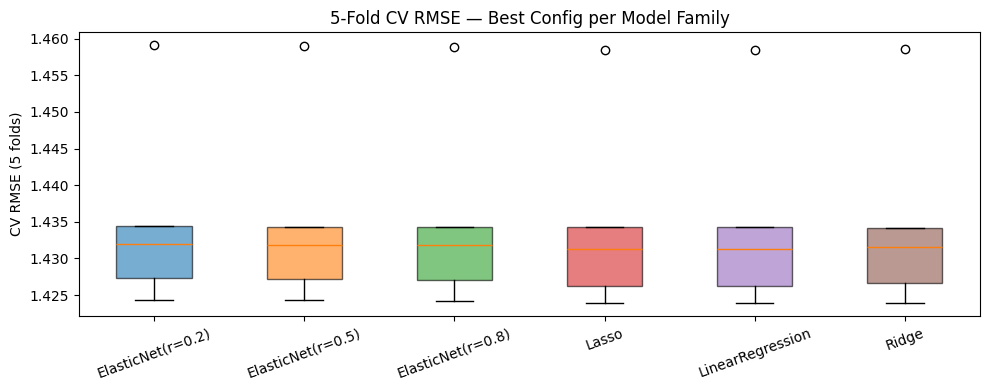

In [202]:
# ── Pick the best alpha per model family from the grid search ─────────────────
# We take the row with the lowest test_rmse for each model family.
# ElasticNet variants are grouped by their full name (which encodes l1_ratio).

best_configs = (
    results_df
    .loc[results_df.groupby("model")["test_rmse"].idxmin()]
    .reset_index(drop=True)
)
print("Best config per model family (by test RMSE):")
display(best_configs[["model", "alpha", "test_rmse", "test_r2"]])

# ── Build the winning pipelines ───────────────────────────────────────────────
def build_pipe(model_name: str, alpha: float) -> Pipeline:
    if model_name == "LinearRegression":
        return Pipeline([("preprocess", preprocess), ("model", LinearRegression())])
    elif model_name == "Ridge":
        return Pipeline([("preprocess", preprocess), ("model", Ridge(alpha=alpha))])
    elif model_name == "Lasso":
        return Pipeline([("preprocess", preprocess), ("model", Lasso(alpha=alpha, max_iter=20000))])
    elif model_name.startswith("ElasticNet"):
        # parse l1_ratio from the encoded name, e.g. "ElasticNet(r=0.5)"
        l1 = float(model_name.split("r=")[1].rstrip(")"))
        return Pipeline([("preprocess", preprocess),
                         ("model", ElasticNet(alpha=alpha, l1_ratio=l1, max_iter=20000))])
    else:
        raise ValueError(f"Unknown model: {model_name}")

# ── 5-fold CV on the BEST config per family ───────────────────────────────────
# cross_val_score returns *negative* RMSE → multiply by -1

cv_rows = []

for _, row in best_configs.iterrows():
    name  = row["model"]
    alpha = row["alpha"]
    pipe  = build_pipe(name, alpha)

    neg_rmse_scores = cross_val_score(
        pipe, X_train, y_train,
        cv=5,
        scoring="neg_root_mean_squared_error"
    )
    rmse_scores = -neg_rmse_scores

    cv_rows.append({
        "model":          name,
        "alpha":          alpha,
        "cv_rmse_mean":   round(rmse_scores.mean(), 4),
        "cv_rmse_std":    round(rmse_scores.std(),  4),
        "fold_scores":    rmse_scores.round(4).tolist(),
        "test_rmse":      row["test_rmse"],   # from grid search — for comparison
    })

    print(f"{name}  (alpha={alpha})")
    print(f"  CV RMSE per fold : {rmse_scores.round(4)}")
    print(f"  Mean CV RMSE     : {rmse_scores.mean():.4f}")
    print(f"  Std  CV RMSE     : {rmse_scores.std():.4f}")
    print()

# ── Summary table ─────────────────────────────────────────────────────────────
cv_summary = pd.DataFrame(cv_rows).sort_values("cv_rmse_mean").reset_index(drop=True)
cv_summary["gap (cv - test)"] = (cv_summary["cv_rmse_mean"] - cv_summary["test_rmse"]).round(4)
print("CV summary (sorted by Mean CV RMSE):")
display(cv_summary[["model", "alpha", "cv_rmse_mean", "cv_rmse_std", "test_rmse", "gap (cv - test)"]])

# ── Boxplot: CV RMSE spread per winning model ─────────────────────────────────
fig, ax = plt.subplots(figsize=(10, 4))
labels = [r["model"] for r in cv_rows]
data   = [r["fold_scores"] for r in cv_rows]
bp = ax.boxplot(data, labels=labels, patch_artist=True)

colors = plt.cm.tab10.colors
for patch, color in zip(bp["boxes"], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

ax.set_ylabel("CV RMSE (5 folds)")
ax.set_title("5-Fold CV RMSE — Best Config per Model Family")
ax.tick_params(axis="x", rotation=20)
plt.tight_layout()
plt.show()

## 16) Gradient Descent — From Scratch



This section is for *conceptual reinforcement*. We re-implement linear regression
using **batch gradient descent** on the same preprocessed design matrix, then compare
results to sklearn's closed-form solution.

**How it works:**
1. Start with `θ = 0` (all-zero coefficients)
2. Compute predictions: `ŷ = X · θ`
3. Compute gradient of MSE: `∇ = (2/m) · Xᵀ(ŷ − y)`
4. Update: `θ ← θ − lr · ∇`
5. Repeat for `n_iter` steps

**Checkpoint (think about these before running):**
- What happens if the learning rate `lr` is too high? Too low?
- How do we know we've converged?
- Why must features be standardised before gradient descent?

## Why Gradient Descent Matters
This section shows *how* models learn under the hood:
- Start with random / zero coefficients
- Iteratively reduce the training error
- Converge toward the optimal solution

Focus on the concept — not every line of maths.


In [203]:
# ── Step 1: Extract the preprocessed design matrix ──────────────────────────
# Reuse the already-fit preprocessor from lr_pipe (section 13)
# Refit here so this cell works even if run out of order
preprocess_fit = preprocess.fit(X_train)

X_train_gd = preprocess_fit.transform(X_train)
X_test_gd  = preprocess_fit.transform(X_test)

# Convert to dense if sparse
X_train_gd = X_train_gd.toarray() if hasattr(X_train_gd, "toarray") else X_train_gd
X_test_gd  = X_test_gd.toarray()  if hasattr(X_test_gd,  "toarray") else X_test_gd

# ── Step 2: Prepend intercept column (column of 1s) ──────────────────────────
X_train_gd = np.c_[np.ones(X_train_gd.shape[0]), X_train_gd]
X_test_gd  = np.c_[np.ones(X_test_gd.shape[0]),  X_test_gd]

print(f"X_train_gd shape: {X_train_gd.shape}  (includes intercept column)")
print(f"X_test_gd  shape: {X_test_gd.shape}")


X_train_gd shape: (28110, 17)  (includes intercept column)
X_test_gd  shape: (9370, 17)


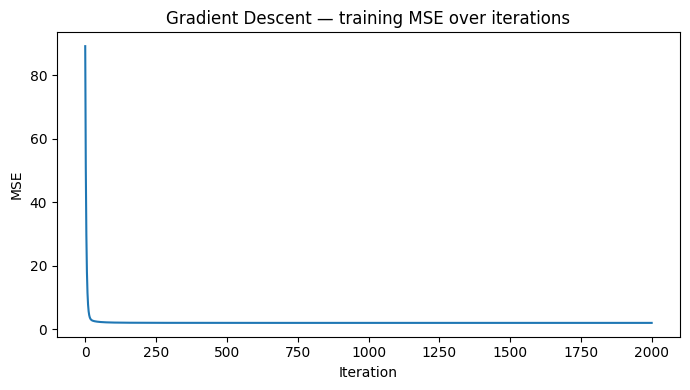

In [204]:
# ── Step 3: Gradient Descent implementation ──────────────────────────────────
def gradient_descent(X, y, lr=0.05, n_iter=2000):
    """Batch gradient descent for linear regression (MSE loss).

    Parameters
    ----------
    X      : (m, n+1) design matrix with intercept column prepended
    y      : (m,) target vector
    lr     : learning rate
    n_iter : number of gradient steps

    Returns
    -------
    theta   : (n+1,) learned coefficient vector
    history : (n_iter,) MSE at each iteration
    """
    theta = np.zeros(X.shape[1])  # initialise all weights at 0
    m = X.shape[0]
    history = []
    for _ in range(n_iter):
        y_pred = X @ theta                          # forward pass
        grad   = (2 / m) * (X.T @ (y_pred - y))    # gradient of MSE
        theta -= lr * grad                          # weight update
        history.append(mean_squared_error(y, y_pred))
    return theta, np.array(history)


theta_gd, mse_hist = gradient_descent(
    X_train_gd, y_train.values, lr=0.05, n_iter=2000
)

# ── Step 4: Plot training MSE convergence ────────────────────────────────────
plt.figure(figsize=(7, 4))
plt.plot(mse_hist, lw=1.5)
plt.title("Gradient Descent — training MSE over iterations")
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.tight_layout()
plt.show()


Model                              RMSE       R²
---------------------------------------------
sklearn LinearRegression         1.4336   0.0391
Gradient Descent (lr=0.05, 2000 iters)   1.4336   0.0391

Both should be very close — gradient descent converges to the same minimum.
If they differ, try increasing n_iter or decreasing lr.


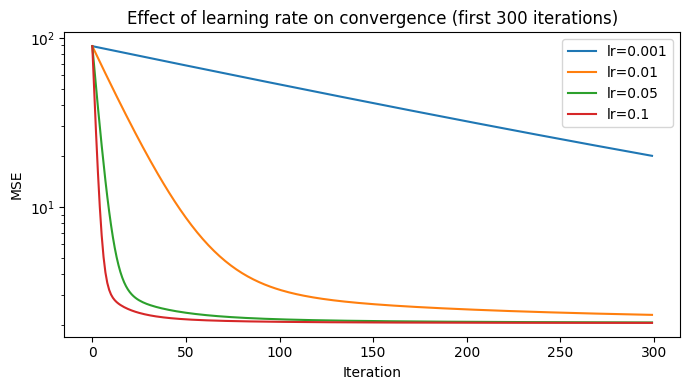

In [205]:
# ── Step 5: Evaluate on test set and compare to sklearn's closed-form ────────
y_test_pred_gd = X_test_gd @ theta_gd

rmse_gd = rmse(y_test, y_test_pred_gd)
r2_gd   = float(r2_score(y_test, y_test_pred_gd))

# Retrieve sklearn closed-form results from section 13
rmse_lr = rmse(y_test, y_test_pred)
r2_lr   = float(r2_score(y_test, y_test_pred))

print("=" * 45)
print(f"{'Model':<30} {'RMSE':>8} {'R²':>8}")
print("-" * 45)
print(f"{'sklearn LinearRegression':<30} {rmse_lr:>8.4f} {r2_lr:>8.4f}")
print(f"{'Gradient Descent (lr=0.05, 2000 iters)':<30} {rmse_gd:>8.4f} {r2_gd:>8.4f}")
print("=" * 45)
print("\nBoth should be very close — gradient descent converges to the same minimum.")
print("If they differ, try increasing n_iter or decreasing lr.")

# sensitivity to learning rate ──────────────────────────────────────
fig, ax = plt.subplots(figsize=(7, 4))
for lr_val in [0.001, 0.01, 0.05, 0.1]:
    _, hist = gradient_descent(X_train_gd, y_train.values, lr=lr_val, n_iter=300)
    ax.plot(hist, label=f"lr={lr_val}")

ax.set_title("Effect of learning rate on convergence (first 300 iterations)")
ax.set_xlabel("Iteration")
ax.set_ylabel("MSE")
ax.legend()
ax.set_yscale("log")
plt.tight_layout()
plt.show()
